In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  # For visualizations
from csaps import csaps #https://csaps.readthedocs.io/en/latest/
import common_functions as func
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit


In [2]:
# Some aesthetic options
np.set_printoptions(suppress=True, linewidth=300, formatter={'float': '{: 0.9f}'.format})
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [15]:
# Global Parameters
starting_age = 20
max_age = 100
N = 100000  # Size of sample populations

# State Structure
health_states = {'healthy': 0,
                 'LR_polyp': 1,
                 'HR_polyp': 2,
                 'u_CRC_loc': 3,
                 'u_CRC_reg': 4,
                 'u_CRC_dis': 5,
                 'd_CRC_loc': 6,
                 'd_CRC_reg': 7,
                 'd_CRC_dis': 8,
                 'cancer_death': 9,
                 'healthy_ACM': 10,
                 'cancer_ACM': 11,
                 'polyp_ACM': 12,  # death while in polyp state
                 'uCRC_ACM': 13}  # death while in undiagnosed state
acm_states = [10,12,12,13,13,13,11,11,11]

# Age Groupings (len=16)
#ages = {"20-25":0, "25-29":1, "30-35":2, "35-39":3, "40-45":4, "45-49":5, "50-54":6, "55-59":7, "60-64":8, 
#        "65-69":9, "70-74":10, "75-79":11, "80-84":12, "85-89":13, "90-95":14, "95+":15}
ages = np.arange(0,80,5)
age_starts = np.arange(20,100,5)
ages = np.arange(0, len(age_starts), 1)

starting_pop = np.zeros((len(health_states),1)) # (14,1)
starting_pop[0,0]=N # Everyone starts in healthy state

### Inputs
# All cause mortality
acm_1y=pd.read_excel("data/acm.xlsx", sheet_name='ACM_1y') # Age, Rate
acm_1y['Age Group'] = (acm_1y['Age'] // 5) * 5
acm_5y = acm_1y.groupby('Age Group')['Rate'].mean().reset_index() 
acm_5y = acm_5y[acm_5y['Age Group']>=20].reset_index() # age_layers 20-100 (16 items)
acm_5y = acm_5y[acm_5y['Age Group']<100].reset_index() # age_layers 20-100 (16 items)
#acm_rate = func.probtoprob(acm_5y['Rate']).to_numpy()
acm_1y = acm_1y[acm_1y['Age']>=20].reset_index()
acm_1y = acm_1y[acm_1y['Age']<100].reset_index(drop=True)
acm_rate = func.probtoprob(acm_5y['Rate']).to_numpy()
# Cancer specific death 
seer_surv = pd.read_excel("data/survival_km.xlsx", sheet_name="Survival").reset_index(drop=True) # In 5y age layers
seer_surv = seer_surv[seer_surv['Age']<100]
csd_rate = seer_surv[['Local', 'Regional', 'Distant']].apply(lambda col: func.probtoprob(col)).to_numpy() # Convert to monthly probs
age_points = np.arange(20, 100, 5)  # Original age points (every 5 years)

# csd_interp = {}
# for col in ['Local', 'Regional', 'Distant']:
#     f = interp1d(age_points, seer_surv[col], kind='linear', fill_value="extrapolate")
#     csd_interp[col] = f(new_age_points)

# csd_rate = pd.DataFrame(csd_interp).apply(lambda col: func.probtoprob(col)).to_numpy()

### Calibration Targets
# Target 1: SEER Incidence
seer_inc = pd.read_excel("data/incidence_crude.xlsx", sheet_name="1975-1990 Adj")
seer_inc = seer_inc[seer_inc['Age']>=20].reset_index() # single ages, 20-84 (65 ages)
seer_inc = seer_inc[seer_inc['Age']<=84].reset_index() # starting age 20, 65 ages

# Target 2: Polyp prevalence
polyp_prev = pd.read_excel("data/polyp_targets.xlsx", sheet_name="Sheet1")
polyp_targets=polyp_prev['Value'].to_numpy() # uCRC, polyp, uCRC + polyp 

In [42]:
def row_normalize(matrix):
    for age_layer in range(matrix.shape[0]): # for every age group (len=16), access health state (14x14) matrix
        layer=matrix[age_layer]
        # Calculate the sum of non-diagonal elements for each row
        sum_of_columns = np.sum(layer, axis=1) - np.diag(layer)
        # Set the diagonal elements
        np.fill_diagonal(matrix[age_layer], 1 - sum_of_columns)
    return matrix

def constrain(matrix):
    # Progression Block
    matrix[:,0,1] = np.maximum(0.00001, matrix[:,0,1])  # not below 0
    matrix[:,0,1] = np.minimum(matrix[:,0,1], matrix[:,1,2])  # Healthy to LR lower than LR to HR
    # matrix[:,2,3] = np.maximum(matrix[:,1,2], matrix[:,2,3])  # HR to Local
    
    # Detection Block
    matrix[:,3,6] = np.maximum(0, matrix[:,3,6])  # not below 0
    matrix[:,4,7] = np.maximum(matrix[:,3,6], matrix[:,4,7])  # P[d_reg] > P[d_loc]
    matrix[:,5,8] = np.maximum(matrix[:,4,7], matrix[:,5,8])  # P[d_dis] > P[d_reg]
    
    return matrix

def add_csd(matrix):
    matrix[:, 6, 9] = csd_rate[:, 0]
    matrix[:, 7, 9] = csd_rate[:, 1]
    matrix[:, 8, 9] = csd_rate[:, 2]
    return matrix

def add_acm(matrix):
    matrix[:,0,10] = acm_rate  # Healthy to ACM
    matrix[:,1:3,12] = acm_rate[:, np.newaxis] # Polyp to ACM
    matrix[:,3:6,13] = acm_rate[:, np.newaxis] # Undiagnosed to ACM
    matrix[:,6:9,11] = acm_rate[:, np.newaxis]  # Cancer to ACM
    
    matrix[:,9,9] = 1  # Stay in CSD
    matrix[:,10,10] = 1  # Stay in ACM
    matrix[:,11,11] = 1  # Stay in Cancer ACM
    matrix[:,12,12] = 1  # Stay in Polyp ACM
    matrix[:,13,13] = 1  # Stay in uCRC ACM

    return matrix 

# Initialize transition probability matrix with zeros
# Dimension 1 represents current states; dimension 2 represents next states
def create_matrix(): #(10,12,12)
    matrix = np.zeros((len(ages), len(health_states), len(health_states))) #size = (ages, n_states, n_states) = (65,14,14)
    # Add transition rates for progression from healthy to cancer
    matrix[:,0,1] = func.probtoprob(0.005)  # healthy to lr_polyp
    matrix[:,1,2] = func.probtoprob(0.015)  # lr_ployp to hr_polyp
    matrix[:,2,3] = func.probtoprob(0.05)  # hr_polyp to u_loc
    matrix[:,3,4] = func.probtoprob(0.45)  # u_loc to u_reg
    matrix[:,4,5] = func.probtoprob(0.50)  # u_reg to u_dis
    
    # Add transition rates for becoming symptomatic/detected
    matrix[:,3,6] = func.probtoprob(0.22)  # u_loc to d_loc
    matrix[:,4,7] = func.probtoprob(0.60)  # u_reg to d_reg
    matrix[:,5,8] = func.probtoprob(0.90)  # u_dis to d_dis
    
    # Other matrix properties
    matrix = add_acm(matrix)  # add death rates
    matrix = add_csd(matrix)  # add death rate
    matrix = constrain(matrix)  # add caps
    matrix = row_normalize(matrix)  # row normalize
    return matrix

def logistic_function(age, L, x0, k):
    """
    Logistic function for fitting.
    L: The curve's maximum value (saturation).
    x0: The x-value of the sigmoid's midpoint.
    k: The logistic growth rate or steepness of the curve.
    """
    return L / (1 + np.exp(-k * (age - x0)))\

def fit_logistic_to_data(ages, data):
    """
    Fit a logistic curve to the provided age and transition data.
    ages: Array of age midpoints (e.g., [22.5, 27.5, ..., 97.5])
    data: Array of transition probabilities corresponding to each age midpoint.
    """
     # Initial guess for parameters
    L_guess = np.max(data)  # Saturation level
    x0_guess = ages[np.argmax(np.diff(data))] if len(data) > 1 else np.median(ages)  # Midpoint where the curve is steepest
    k_guess = np.abs((data[-1] - data[0]) / (ages[-1] - ages[0]))  # Positive slope guess

    initial_guess = [L_guess, x0_guess, k_guess]

    # Set parameter bounds to ensure increasing logistic function
    bounds = ([0, np.min(ages), 0], [np.max(data) * 2, np.max(ages), np.inf])

    # Fit logistic function to the data with constraints
    popt, _ = curve_fit(logistic_function, ages, data, p0=initial_guess, bounds=bounds, maxfev=10000)
    return popt

def interp_matrix(matrix):
    age_mids = np.array([22.5,27.5,32.5,37.5,42.5,47.5,52.5,57.5,62.5,67.5,72.5,77.5,82.5,87.5,92.5,97.5])
    # age_mids_sub = age_mids[5:]
    # tmat_sub = matrix[5:]
    
    tsmooth_spline = csaps(age_mids, matrix, smooth=.001, axis=0)
    # tsmooth_sub = csaps(age_mids_sub, tmat_sub, smooth=0.01, axis=0)

    update = tsmooth_spline(age_mids).clip(0.00000001,0.6)
    # update_sub = tsmooth_sub(age_mids).clip(0.00000001,0.6)

    new_matrix = np.zeros_like(matrix)
    new_matrix[:,0,1] = update[:,0,1]
    new_matrix[:,1,2] = update[:,1,2]
    new_matrix[:,2,3] = update[:,2,3]
    new_matrix[:,3,4] = update[:,3,4]
    new_matrix[:,4,5] = update[:,4,5]
    new_matrix[:,3,6] = update[:,3,6]
    new_matrix[:,4,7] = update[:,4,7]
    new_matrix[:,5,8] = update[:,5,8]

    # new_matrix_sub = np.zeros_like(matrix)
    # new_matrix_sub[:,0,1] = update_sub[:,0]
    # new_matrix_sub[:,1,2] = update_sub[:,1]
    # new_matrix_sub[:,2,3] = update_sub[:,2]
    # new_matrix_sub[:,3,4] = update_sub[:,3]
    # new_matrix_sub[:,4,5] = update_sub[:,4]
    # new_matrix_sub[:,3,6] = update_sub[:,5]
    # new_matrix_sub[:,4,7] = update_sub[:,6]
    # new_matrix_sub[:,5,8] = update_sub[:,7]

    if not np.all(np.diff(update[6:,0,1]) > 0):
        update[7:,0,1] = update[6,0,1,np.newaxis]
        
    return new_matrix

def interp_matrix_logistic(matrix):
    """
    Interpolate the transition matrix using logistic fitting.
    matrix: Transition matrix containing transition probabilities for each age group.
    age_mids: Midpoints of the age intervals used in the original data.
    """
    new_matrix = np.zeros_like(matrix)
    age_mids = np.array([22.5,27.5,32.5,37.5,42.5,47.5,52.5,57.5,62.5,67.5,72.5,77.5,82.5,87.5,92.5,97.5])
    # Iterate over all transitions we want to fit logistic curves for
    for (from_state, to_state) in [(0,1), (1,2), (2,3), (3,4), (4,5), (3,6), (4,7), (5,8)]:
        # Extract data for fitting
        data = matrix[:, from_state, to_state]
        
        # Fit logistic curve to the data points
        L, x0, k = fit_logistic_to_data(age_mids, data)
        
        # Interpolate new values using the fitted logistic curve
        interpolated_values = logistic_function(age_mids, L, x0, k)
        
        # Update the transition matrix with interpolated values
        new_matrix[:, from_state, to_state] = interpolated_values

    return new_matrix


def run_markov(matrix, starting_age=20, max_age=100):
    current_age = starting_age
    stage = 0 
    month_pop, pop_log = starting_pop, starting_pop
    inc_log = np.zeros(pop_log.shape)  # to track new incidences in each state 
    age_layer = 0
    mat = matrix[age_layer]
    mat = mat.T
    inflow_mat = np.tril(mat, k=-1)
    while current_age < max_age:
        # Get incidence of current month's transitions
        month_inc = np.matmul(inflow_mat, month_pop) #(14,14)(14,1)-->(14,1)
        # Actually make transitions
        month_pop = np.matmul(mat, month_pop)
        # Add to log
        inc_log = np.concatenate((inc_log, month_inc), axis=1)
        pop_log = np.concatenate((pop_log, month_pop), axis=1)
        stage += 1
        if stage % 12 == 0:
            current_age += 1
            if current_age in [25,30,35,40,45,50,55,60,65,70,75,80,85,90,95]:
                age_layer += 1
                mat = matrix[age_layer].T
                inflow_mat = np.tril(mat, k=-1)
            

    inc_log = inc_log[:, 1:] # make (14,960)
    inc_rate = inc_log.copy() # make (14,960)
    pop_log = pop_log[:, 1:] # make (14,960)
    
    dead_factor = np.divide(N, N-pop_log[9:,:].sum(axis=0)) # inc and prev denominator is out of living only
    prevalence = np.zeros(pop_log.shape) #(14,80)
    
    for state in range(14):
        inc_rate[state,:] = np.multiply(inc_rate[state,:], dead_factor) 
        prevalence[state,:] = np.multiply(pop_log[state,:], dead_factor)

    inc_rate = inc_rate.reshape(len(health_states),80,12).sum(axis=2) # getting annual incidence (rate per 100k)
    inc_log = inc_log.reshape(len(health_states),80,12).sum(axis=2) # getting inc unadjusted
    prevalence = prevalence.reshape(len(health_states),80,12).mean(axis=2) #getting mean annual prevalence

    return inc_rate, prevalence, pop_log, inc_log
# Calculate score based on difference between model outputs and targets
def objective(log, i):
    inc, _, _, inc_log = log
    score = 0
    
    # Yearly incidence penalty (20-84)
    score += np.square(inc[6,:65] - seer_inc['Local Rate']).sum()
    score += np.square(inc[7,:65] - seer_inc['Regional Rate']).sum()
    score += np.square(inc[8,:65] - seer_inc['Distant Rate']).sum() 
    
    # Polyp prevalence penalty (pooled)
    score += (1/np.sqrt(35656))*np.square(inc_log[12,:].sum() - N*polyp_targets[1]) # polyps
    score += (1/np.sqrt(31434))*np.square(inc_log[13,:].sum() - N*polyp_targets[0]) # uCRC

    # Penalty to ensure plateau
    post_80_inc = inc[6:9, 60:] # Assuming the array index 60 corresponds to age 80
    years_after_80 = np.arange(1, post_80_inc.shape[1])  # 1, 2, 3,... for years after 80
    score += 0.1 * np.sum(np.square(np.diff(post_80_inc)) * years_after_80)
    
    return score

points = [(0,1),(1,2),(2,3),(3,4),(4,5),(3,6),(4,7),(5,8)] #(8 possible points to adjust)
def step(matrix, step_size, num_adj=7): 
    new_matrix=np.copy(matrix)
    age_layers = np.random.randint(len(ages), size=num_adj)
    cells = np.random.choice(len(points), size=num_adj, replace=True)
    for i in range(num_adj):
        new_matrix[age_layers[i], points[cells[i]][0], points[cells[i]][1]] += np.random.uniform(low=-step_size, high=step_size)
    new_matrix = interp_matrix(new_matrix)
    new_matrix = add_acm(new_matrix)
    new_matrix = add_csd(new_matrix)
    new_matrix = constrain(new_matrix)
    new_matrix = row_normalize(new_matrix)
    return new_matrix

def simulated_annealing(n_iterations, step_size, start_tmat=None, n_adj=7, verbose=False):
    if start_tmat is None:
        raise ValueError("Need tmat")
    else:
        best_tmat = np.copy(start_tmat)
    best_log = run_markov(best_tmat)
    best_eval = objective(best_log,1)  # evaluate the initial point
    curr_tmat, curr_eval = best_tmat, best_eval  # current working solution
    
    for i in range(n_iterations):  
        # Run model 
        candidate_tmat = np.copy(curr_tmat)
        candidate_tmat = step(candidate_tmat, step_size, n_adj)
        candidate_log = run_markov(candidate_tmat)
        candidate_eval = objective(candidate_log,i)  # Evaluate candidate point
        
        # Update "best" if better than candidate
        if candidate_eval < best_eval:
            best_tmat, best_eval = np.copy(candidate_tmat), np.copy(candidate_eval) 
            best_log = run_markov(best_tmat)
        # t = 10 / float(i+1)  # calculate temperature for current epoch
        t = 1 /(1+np.log(i+1))
        
        if i%100==0:
            candidate_tmat = interp_matrix_logistic(candidate_tmat)
            
        # Progress report
        if verbose and i%500==0:
            inc_log=best_log[3]
            total_dxd=np.sum(inc_log[6:9,:])/N 
            print(i, ": ", best_eval,"   CRC: ", round(total_dxd,5))

        # Check if we should update "curr"
        diff = candidate_eval - curr_eval  # difference between candidate and current point evaluation
        metropolis = np.exp(-diff / t)  # calculate metropolis acceptance criterion        
        if diff < 0 or np.random.random() < metropolis:  # check if we should keep the new point
            curr_tmat, curr_eval = candidate_tmat, candidate_eval  # store the new current point
        
    print(best_eval)
    return best_tmat

In [43]:
tmat = create_matrix()
result = simulated_annealing(10000, 0.01, start_tmat=tmat, n_adj=5, verbose=True)
#result = simulated_annealing(50000, 0.005, start_pmat=result[0], start_tmat=result[1], n_adj=15, verbose=True)
#result = simulated_annealing(20000, 0.001, start_pmat=result[0], start_tmat=result[1], n_adj=7, verbose=True)

0 :  147182.4660645188    CRC:  0.05328


C:\Users\sophi\AppData\Local\Temp\ipykernel_24356\4208207032.py:265: RuntimeWarning: overflow encountered in exp
  metropolis = np.exp(-diff / t)  # calculate metropolis acceptance criterion


500 :  12272.946662139095    CRC:  0.0579
1000 :  7601.3699836479145    CRC:  0.05841
1500 :  5112.1584424618895    CRC:  0.0574
2000 :  3451.4402736621832    CRC:  0.05906
2500 :  3028.314767941188    CRC:  0.05836
3000 :  2190.973754328131    CRC:  0.05774
3500 :  2190.973754328131    CRC:  0.05774
4000 :  2190.973754328131    CRC:  0.05774
4500 :  2190.973754328131    CRC:  0.05774
5000 :  2190.973754328131    CRC:  0.05774
5500 :  2129.017643962663    CRC:  0.05828
6000 :  2129.017643962663    CRC:  0.05828
6500 :  2129.017643962663    CRC:  0.05828
7000 :  2129.017643962663    CRC:  0.05828
7500 :  2129.017643962663    CRC:  0.05828
8000 :  2129.017643962663    CRC:  0.05828
8500 :  2129.017643962663    CRC:  0.05828
9000 :  2129.017643962663    CRC:  0.05828
9500 :  2129.017643962663    CRC:  0.05828
2129.017643962663


In [44]:
curr_tmat = result.copy()
curr_log = run_markov(curr_tmat)

## Analyze transition probabilities

In [45]:
# Function to extract transition probabilities
def extract_transition_probs(tmat, states, transitions):
    transition_probs = {}
    for from_state, to_state in transitions:
        from_idx = states[from_state]
        to_idx = states[to_state]
        params = tmat[:, from_idx, to_idx]
        transition_probs[f"{from_state} to {to_state}"] = params
    return transition_probs

# Print the transition probabilities in a readable format
def print_trans_probs(transition_probs):
    print("Monthly transition probs")
    for transition, prob in transition_probs.items():
        print(f"{transition}: {prob[6]:.5f}")

    print("\nAnnual transition probs")
    for transition, prob in transition_probs.items():
        annual_prob = func.probtoprob(prob[6], 12, 1)
        print(f"{transition}: {annual_prob:.5f}")

desired_transitions = [
    ('healthy', 'LR_polyp'),
    ('LR_polyp', 'HR_polyp'),
    ('HR_polyp', 'u_CRC_loc'),
    ('u_CRC_loc', 'u_CRC_reg'),
    ('u_CRC_reg', 'u_CRC_dis'),
    ('u_CRC_loc', 'd_CRC_loc'),
    ('u_CRC_reg', 'd_CRC_reg'),
    ('u_CRC_dis', 'd_CRC_dis')
]

In [46]:
transition_probs = extract_transition_probs(curr_tmat, health_states, desired_transitions)
print_trans_probs(transition_probs)

Monthly transition probs
healthy to LR_polyp: 0.00047
LR_polyp to HR_polyp: 0.00144
HR_polyp to u_CRC_loc: 0.00173
u_CRC_loc to u_CRC_reg: 0.04401
u_CRC_reg to u_CRC_dis: 0.04588
u_CRC_loc to d_CRC_loc: 0.02468
u_CRC_reg to d_CRC_reg: 0.07659
u_CRC_dis to d_CRC_dis: 0.17668

Annual transition probs
healthy to LR_polyp: 0.00566
LR_polyp to HR_polyp: 0.01714
HR_polyp to u_CRC_loc: 0.02057
u_CRC_loc to u_CRC_reg: 0.41734
u_CRC_reg to u_CRC_dis: 0.43081
u_CRC_loc to d_CRC_loc: 0.25906
u_CRC_reg to d_CRC_reg: 0.61563
u_CRC_dis to d_CRC_dis: 0.90299


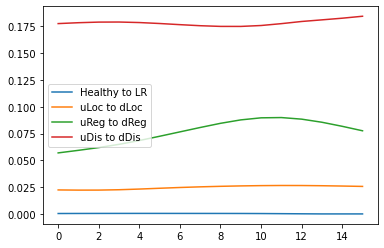

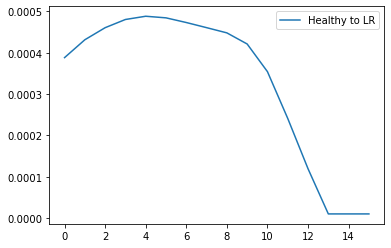

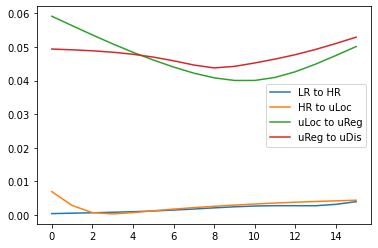

In [47]:
def plot_tps(curr_tmat):
    plt.plot(curr_tmat[:,0,1], label = "Healthy to LR")
    plt.plot(curr_tmat[:,3,6], label = "uLoc to dLoc")
    plt.plot(curr_tmat[:,4,7], label = "uReg to dReg")
    plt.plot(curr_tmat[:,5,8], label = "uDis to dDis")
    plt.legend()
    plt.show()

    plt.plot(curr_tmat[:,0,1], label = "Healthy to LR")
    plt.legend()
    plt.show()

    plt.plot(curr_tmat[:,1,2], label = "LR to HR")
    plt.plot(curr_tmat[:,2,3], label = "HR to uLoc")
    plt.plot(curr_tmat[:,3,4], label = "uLoc to uReg")
    plt.plot(curr_tmat[:,4,5], label = "uReg to uDis")
    plt.legend()
    plt.show()

plot_tps(curr_tmat)


### Plot vs. SEER incidence

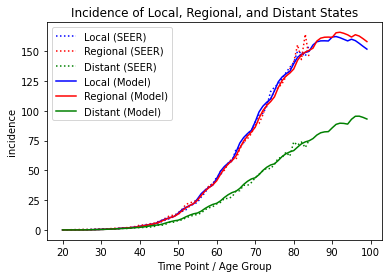

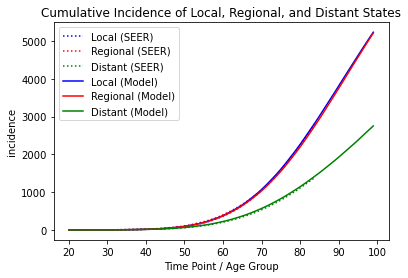

In [41]:
### Plotting
def plot_vs_seer(curr_log):
    inc_adj, _,_,_ = curr_log
    x_values = np.linspace(20,99,80)

    plt.plot(seer_inc['Age'], seer_inc['Local Rate'], label = 'Local (SEER)', color='b',linestyle="dotted")
    plt.plot(seer_inc['Age'], seer_inc['Regional Rate'], label = 'Regional (SEER)', color='r', linestyle="dotted")
    plt.plot(seer_inc['Age'], seer_inc['Distant Rate'],  label='Distant (SEER)', color='g',linestyle="dotted")
    plt.plot(x_values, inc_adj[6,:], label='Local (Model)', color='b')
    plt.plot(x_values, inc_adj[7,:],  label='Regional (Model)', color='r')
    plt.plot(x_values, inc_adj[8,:],  label='Distant (Model)', color='g')
    plt.legend()
    plt.title('Incidence of Local, Regional, and Distant States')
    plt.xlabel('Time Point / Age Group')
    plt.ylabel('incidence')
    plt.show()

    plt.plot(seer_inc['Age'], seer_inc['Local Rate'].cumsum(), label = 'Local (SEER)', color='b',linestyle="dotted")
    plt.plot(seer_inc['Age'], seer_inc['Regional Rate'].cumsum(), label = 'Regional (SEER)', color='r',linestyle="dotted")
    plt.plot(seer_inc['Age'], seer_inc['Distant Rate'].cumsum(), label = 'Distant (SEER)', color='g',linestyle="dotted")
    plt.plot(x_values, inc_adj[6,:].cumsum(), label='Local (Model)', color='b')
    plt.plot(x_values, inc_adj[7,:].cumsum(), label='Regional (Model)', color='r')
    plt.plot(x_values, inc_adj[8,:].cumsum(), label='Distant (Model)', color='g')
    plt.legend()
    plt.title('Cumulative Incidence of Local, Regional, and Distant States')
    plt.xlabel('Time Point / Age Group')
    plt.ylabel('incidence')
    plt.show()

plot_vs_seer(curr_log)